# Jeff's hot garbage

Jeff made this at the 2024 RDKit UGM hackathon, using code from Ibrahim's [example notebook](https://github.com/PDBeurope/pdbe-notebooks/blob/ca960f85b1b15eee15bb19ec6d74036fd0e9254c/pdbeccdutils_tutorials/spring_school_cadd/pdbeccdutils.ipynb). 

Ibrahim showed this super nasty structure from the PDB - [1d83](https://www.ebi.ac.uk/pdbe/entry/pdb/1d83), which includes both a double-stranded nucleic acid and some weird modified carbohydrate hanging out in its groove. I wondered if we could simulate it. 

Turns out, we can do the hard part, but not the easy part. Ibrahim made a function that loads covalently linked components (clcs) into RDKit Molecules, which is amazing. So this notebook loads and simulates that thing. Unfortunately we couldn't think of an easy way to load the nucleic acid into an RDMol (though the `1d83_updated` file that gets fetched DOES have bond orders for the NA)

The install instructions for this are probably something like `mamba create -n blah openff-toolkit-examples` `mamba activate blah` `pip install pdbeccdutils`

In [1]:
import os
import gzip
import requests
from enum import Enum
from typing import NamedTuple
import pandas as pd
from collections import defaultdict
from typing import List, Set, Dict
from gemmi import cif
from pdbeccdutils.core.component import Component

In [2]:
from pdbeccdutils.helpers import cif_tools
from pdbeccdutils.core.boundmolecule import infer_bound_molecules
from pdbeccdutils.core import clc_reader
from pdbeccdutils.core import ccd_reader

In [3]:
ENTRY_URL = "https://ftp.ebi.ac.uk/pub/databases/msd/updated_mmcif/all"

def get_entry_cif(pdb_id: str) -> str:
    """
    Downloads and writes PDB entry updated mmCIF to a file and 
    returns the path

    Args:
        pdb_id: PDB id of an entry

    Returns:
        path to the downloaded file
    """
    entry_url = os.path.join(ENTRY_URL, f"{pdb_id}_updated.cif.gz")
    response = requests.get(entry_url, stream=True)
    response.raise_for_status()
    with open(f"{pdb_id}_updated.cif", "wb") as fh:
        fh.write(gzip.decompress(response.content))

    return f"{pdb_id}_updated.cif"

In [4]:
def get_clc(pdb_id: str) -> list[clc_reader.CLCReaderResult]:
    """
    Returns a list of CLCReaderResults containing Component 
    object of Covalently Linked Components (CLCs)

    Args:
        pdb_id: PDB ID of an entry

    """
    input_cif = get_entry_cif(pdb_id)
    fixed_mmcif_file = os.path.join(f"{pdb_id}_processed.cif")

    #Keeps only first model, removes alternate conformations of atoms and residues
    cif_tools.fix_updated_mmcif(input_cif, fixed_mmcif_file)

    #
    bms = infer_bound_molecules(
    fixed_mmcif_file, ["HOH"], assembly=False
)
    clc_reader_results = []
    for i, bm in enumerate(bms, start=1):
        bm_id = f"bm{i}"
        reader_result = clc_reader.infer_multiple_chem_comp(
            fixed_mmcif_file, bm, bm_id, sanitize=True
        )
        if reader_result:
            clc_reader_results.append(reader_result)
    
    return clc_reader_results


In [5]:
disasters = get_clc("1d83")


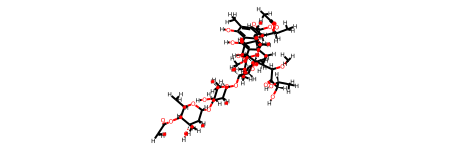

In [6]:
disasters[1].component.mol

In [7]:
from openff.toolkit import Topology, Molecule, ForceField
from openff.toolkit.utils.nagl_wrapper import NAGLToolkitWrapper
from rdkit.Chem import AllChem
top = Topology()
ntkw = NAGLToolkitWrapper()
for disaster in disasters:
    # Thanks to Nicolai Ree for showing that we can quickly fix the hydrogen 
    # positions here instead of needing to do a big interchange minimization later
    AllChem.MMFFOptimizeMoleculeConfs(disaster.component.mol, maxIters=2000, nonBondedThresh=100.0)

    offmol = Molecule.from_rdkit(disaster.component.mol)
    ntkw.assign_partial_charges(offmol, "openff-gnn-am1bcc-0.1.0-rc.3.pt")
    top.add_molecule(offmol)
ff = ForceField("openff-2.2.0.offxml")

interchange = ff.create_interchange(top, charge_from_molecules=top.molecules)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [8]:
# ~The hydrogen placements really suck for some reason so we have to minimize aggressively~
# UPDATE: Now resolved by minimizing in RDKit above. 
# The real fix should probably go upstream in pdbeccdutils, since there are good looking Hs in 
# the 1d89_updated file, so something in the loading process must be removing them
interchange.visualize()

NGLWidget()

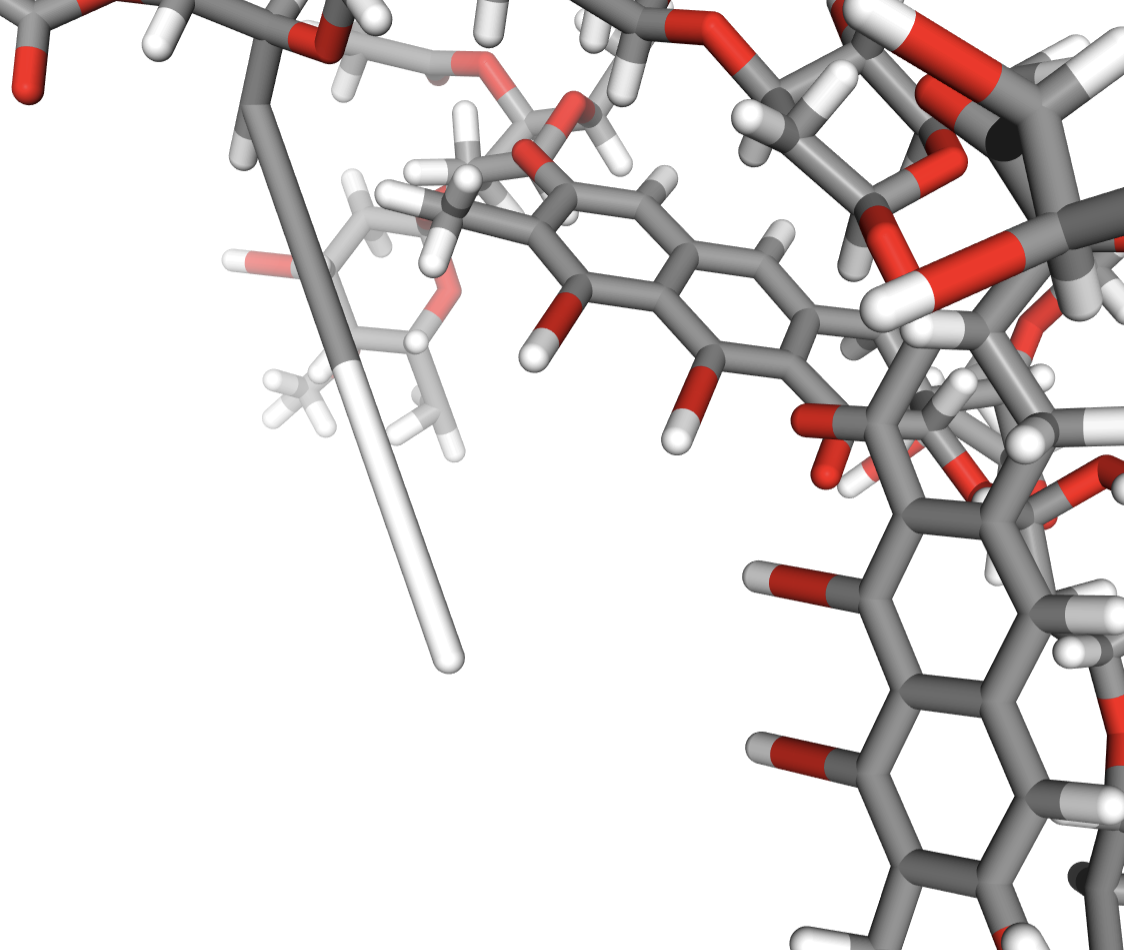

In [9]:
# ~For some reason I have to run this like 3 times to get it to actaully run~
# Update: Now this may not be necessary since the Hs are fixed.
from openff.units import unit
interchange.minimize(force_tolerance=.001 * unit.kilojoule / unit.mol /unit.nm,
                    max_iterations=1000000)
interchange.visualize()

NGLWidget()

In [10]:
import openmm
import nglview
import mdtraj
# OpenMM setup boilerplate
integrator = openmm.LangevinMiddleIntegrator(
        300 * openmm.unit.kelvin,
        1 / openmm.unit.picosecond,
        0.002 * openmm.unit.picoseconds,
    )

simulation = interchange.to_openmm_simulation(integrator)
simulation.minimizeEnergy(tolerance=0.001)
dcd_reporter = openmm.app.DCDReporter(file="trajectory.dcd", 
                                      reportInterval=10
                                     )
simulation.reporters.append(dcd_reporter)
simulation.step(1000)
# Visualize the trakectory
trajectory: mdtraj.Trajectory = mdtraj.load(
    "trajectory.dcd", top=mdtraj.Topology.from_openmm(interchange.to_openmm_topology())
)
trajectory.superpose(trajectory[0])
view = nglview.show_mdtraj(trajectory)
view.add_representation("line", selection="protein")
view.add_line(selection="water")
view

NGLWidget(max_frame=99)